In [ ]:
#TODO: check low r2 of gain only model

In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

import scienceplots
import shutup

from joblib import Parallel, delayed

from lib import data, spks_utils, fitlvm_utils, fit_models, eval_models, models, utils

%load_ext autoreload
%autoreload 2

In [2]:
# pretty plots
plt.style.use(['nature'])
plt.rcParams['figure.dpi'] = 200
%matplotlib widget

# seed and suppress warnings :-)
fit_models.seed()
shutup.please()

In [3]:
trial_data_all = np.load("vars/trial_data_all_MM012_MM013_5sess.npz", allow_pickle=True)['arr_0']
session_data_all = np.load("vars/session_data_all_MM012_MM013_5sess.npy", allow_pickle=True)
unit_spike_times_all = np.load("vars/unit_spike_times_all_MM012_MM013_5sess.npy", allow_pickle=True)
regions_all = np.load("vars/regions_all.npy", allow_pickle=True)

## NB

In [4]:
subj_idx = 0; sess_idx = 3

unit_spike_times = unit_spike_times_all[subj_idx][sess_idx]
trial_data = trial_data_all[subj_idx][sess_idx]
session_data = session_data_all[subj_idx][sess_idx]
regions = regions_all[subj_idx][sess_idx]

In [9]:
trial_data['block_side'] = np.where(trial_data['current_block_side'] == 'left', 1, -1)

In [73]:
psths, _, _, _, _, _, mask = data.get_psths(unit_spike_times, trial_data, session_data, regions, 
                                tpre=0.5, tpost=0.5, binwidth_ms=25, alignment='choice', 
                            balance=True, reward_only=False, do_rem_zstd=True, shuffle=False, prev_filter=False)
trial_data = trial_data[mask]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

ntents=5
data_gd, train_dl, val_dl, test_dl, train_inds, val_inds, test_inds, Mtrain, Mtest, sample, num_trials, num_tv, num_units = fitlvm_utils.get_data_model(psths, trial_data, regions, norm=True, num_tents=ntents, task_vars=['response', 'rewarded', 'block_side']) #, 'response_prev', 'rewarded_prev'])

0 291 96 16
originally 187 units
good units 187
403 Trials, 187 Neurons


In [74]:
# MODELING
# Step 0: Check if dataset has stable low-dim structure at 4+ dims
print("Step 0")
cids_pca = fitlvm_utils.check_stable_lowd(data_gd, Mtrain, Mtest, num_units)

# Step 1: Fit baseline model
# > Baseline model: has no task vars, can capture slow drift in firing rate for each unit using b0-splines
print("Step 1: Baseline")
mod_baseline = fitlvm_utils.fit_baseline(train_dl, val_dl, num_tv, num_units, ntents=ntents)

Step 0
Found 157 /187 units with stable low-dimensional structure at rank 1
Step 1: Baseline
Fitting baseline model...done


In [75]:
# Step 2: Fit model with task vars and slow drift
# > Task vars & slow drift: Used to identify units driven by task vars
def fit_tvs(train_dl, val_dl, num_tv, num_units, mod_baseline, ntents=5):
    mod_tv = models.SharedGain(num_tv,
            num_units=num_units,
            cids=None,
            num_latent=1,
            num_tents=ntents,
            include_tv=True,
            include_gain=False,
            include_offset=False,
            tents_as_input=False,
            output_nonlinearity='Identity',
            latent_noise=True,
            tv_act_func='lin',
            tv_reg_vals={'l2':0.001},
            reg_vals={'l2':0.001},
            act_func='lin')

    mod_tv.drift.weight.data = mod_baseline.drift.weight.data.clone()

    print("Fitting task variable model...", end="")
    fitlvm_utils.fit_model(mod_tv, train_dl, val_dl, verbose=0, use_lbfgs=True)
    print("done")

    return mod_tv

from sklearn.linear_model import RidgeCV
def fit_tvs_ridge(train_dl, mod_baseline):
    # just use sklearn ridge at first
    mod_tv = RidgeCV(alphas=np.logspace(-5, 4, 10, base=10), store_cv_results=True)

    robs_bl_res = train_dl.dataset[:]['robs'] - mod_baseline(train_dl.dataset[:]).detach().numpy()
    
    print("Fitting task variable model...", end="")
    mod_tv.fit(train_dl.dataset[:]['tv'], robs_bl_res)
    print("done")
    return mod_tv

In [76]:
# Step 2: Fit model with task vars and slow drift
# > Task vars & slow drift: Used to identify units driven by task vars
print("Step 2: Task Var")
mod_tv = fit_tvs_ridge(train_dl, mod_baseline)
print("alpha", mod_tv.alpha_) 

Step 2: Task Var
Fitting task variable model...done
alpha 1.0


C:\Users\danci\AppData\Local\Temp\ipykernel_20452\561091227.py:33: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  robs_bl_res = train_dl.dataset[:]['robs'] - mod_baseline(train_dl.dataset[:]).detach().numpy()


In [77]:
robs = test_dl.dataset[:]['robs']
rhat_tv = mod_tv.predict(test_dl.dataset[:]['tv']) + mod_baseline(test_dl.dataset[:]).detach().numpy()
res = robs - rhat_tv
# robs_bl_res = train_dl.dataset[:]['robs'] - mod_baseline(train_dl.dap

C:\Users\danci\AppData\Local\Temp\ipykernel_20452\632296817.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  res = robs - rhat_tv


In [78]:
r2_tv = fitlvm_utils.rsquared(robs, rhat_tv)

In [79]:
from copy import deepcopy
# mod_tv_nolatent = deepcopy(mod_tv)
# mod_tv_nolatent.readout_offset.weight.data[:] = 0
# res_tv_nolatent = fitlvm_utils.eval_model(mod_tv, data_gd, test_dl.dataset)

robs = val_dl.dataset[:]['robs']
# rhat = res_tv_nolatent['rhat']
res = robs - rhat_tv

block_side = trial_data['block_side'] # np.where(trial_data['block_side']=='left', 1, -1)
choice = trial_data['response']
reward = trial_data['rewarded']

rob_block_corr = utils.spearmanr_vec(block_side, robs)
rob_choice_corr = utils.spearmanr_vec(choice, robs)
rob_reward_corr = utils.spearmanr_vec(reward, robs)
res_block_corr = utils.spearmanr_vec(block_side, res)
res_choice_corr = utils.spearmanr_vec(choice, res)
res_reward_corr = utils.spearmanr_vec(reward, res)

C:\Users\danci\AppData\Local\Temp\ipykernel_20452\3630247774.py:8: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  res = robs - rhat_tv


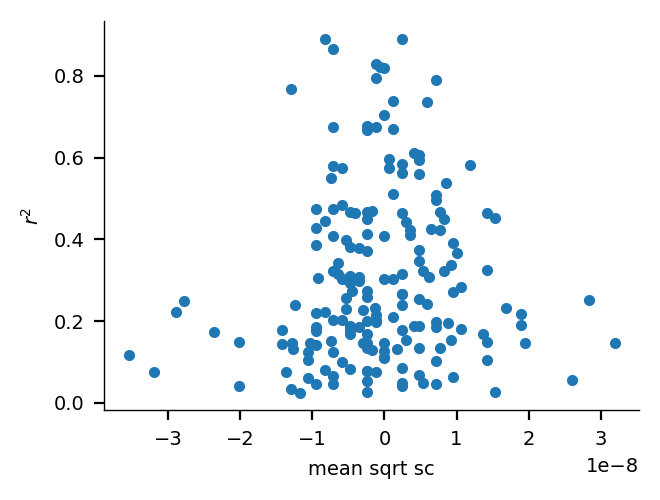

In [23]:
plt.figure()
plt.scatter(torch.mean(robs, axis=0), r2_tv)
plt.xlabel("mean sqrt sc"); plt.ylabel(fr"$r^2$")
plt.tight_layout()
plt.show()

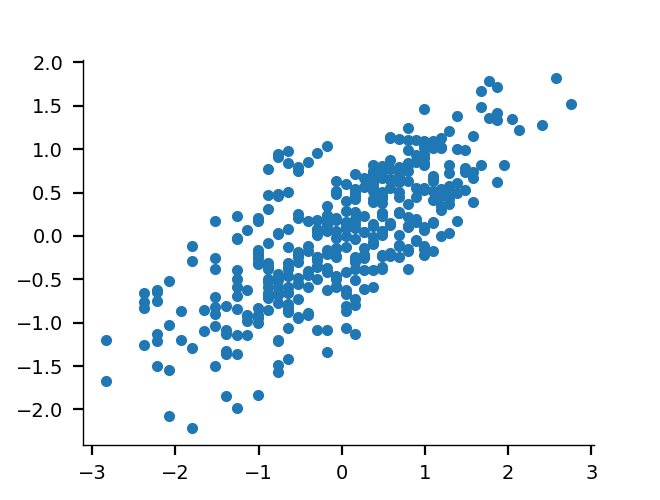

In [24]:
plt.figure()
plt.scatter(robs[:,7], res[:,7])
plt.show()

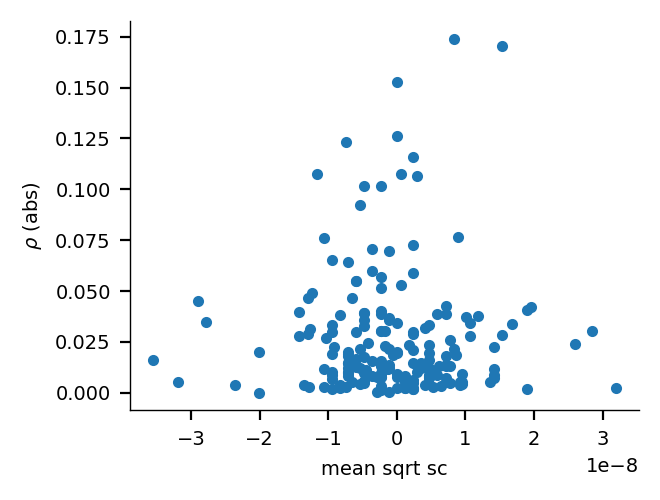

In [32]:
plt.figure()
plt.scatter(torch.mean(robs, axis=0), np.abs(res_block_corr))
plt.xlabel("mean sqrt sc"); plt.ylabel(fr"$\rho$ (abs)")
plt.tight_layout()
plt.show()

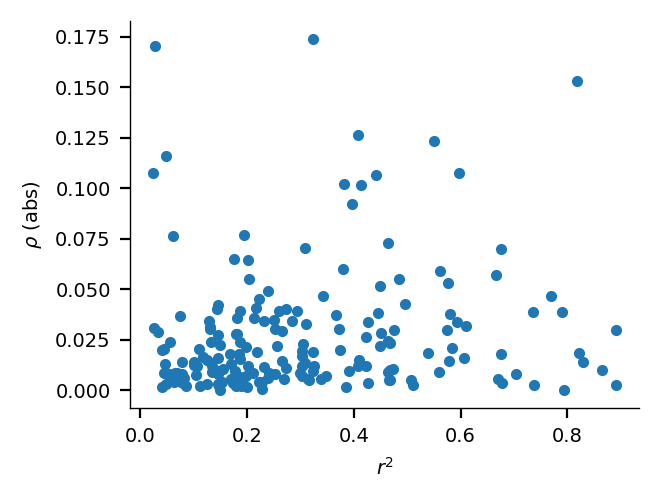

In [33]:
plt.figure()
plt.scatter(r2_tv, np.abs(res_block_corr))
plt.xlabel("$r^2$"); plt.ylabel(fr"$\rho$ (abs)")
plt.tight_layout()
plt.show()

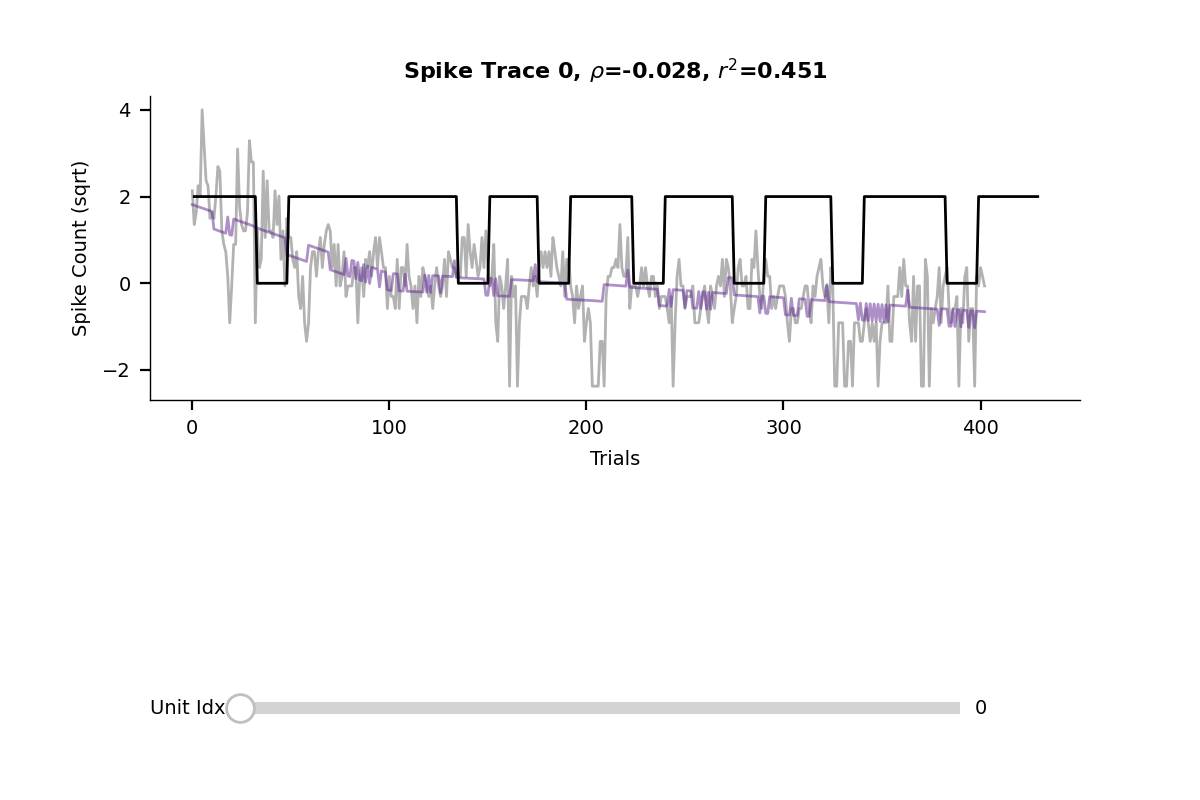

In [34]:
from matplotlib.widgets import Slider


num_traces = robs.shape[1]
# plot first trace
fig, ax = plt.subplots(figsize=(6, 4))
plt.subplots_adjust(bottom=0.5)

curr_idx = 0
trace_robs, = ax.plot(robs[:,curr_idx], color='#666666', alpha=0.5, label="Observed")
trace_rhat, = ax.plot(rhat_tv[:,curr_idx], alpha=0.5, color="#5C2392", label="Predicted")
# trace_res,  = ax.plot(res[:, curr_idx], alpha=0.5, color="red", label="Residual")
ax.plot(block_side+1, linewidth=1, color='k')
        
ax.set_title(fr"Spike Trace {curr_idx}, $\rho$={res_block_corr[curr_idx]:.3f}, $r^2$={r2_tv[curr_idx]:.3f}")
ax.set_xlabel("Trials")
ax.set_ylabel("Spike Count (sqrt)")

# slider
ax_slider = plt.axes([0.2, 0.1, 0.6, 0.03])
slider = Slider(
    ax=ax_slider,
    label="Unit Idx",
    valmin=0,
    valmax=num_traces - 1,
    valinit=0,
    valstep=1  # makes slider move in integers
)

# update
def update(val):
    update_idx = int(slider.val)
    trace_robs.set_ydata(robs[:, update_idx])
    trace_rhat.set_ydata(rhat_tv[:,update_idx])
    # trace_res.set_ydata(res[:,update_idx])
    ax.relim()
    ax.autoscale_view()
    ax.set_title(fr"Unit {update_idx}, $\rho$={res_block_corr[update_idx]:.3f}, $r^2$={r2_tv[update_idx]:.3f}")
    fig.canvas.draw_idle()

slider.on_changed(update)

def on_key(event):
    step = 1
    if event.key == 'right':
        slider.set_val(slider.val + step)
    elif event.key == 'left':
        slider.set_val(slider.val - step)

fig.canvas.mpl_connect('key_press_event', on_key)

plt.show()

In [42]:
# split residual based on block
left_block_idx  = np.where(block_side==1)[0]
right_block_idx = np.where(block_side==-1)[0]
res_left  = res[left_block_idx,:]
res_right = res[right_block_idx,:]

In [ ]:
# add no choice as intercept

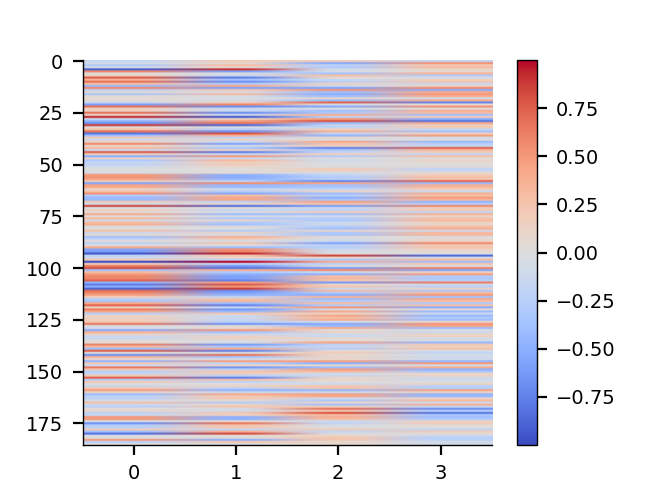

In [44]:
plt.figure(); plt.imshow(mod_tv.coef_, cmap='coolwarm', aspect='auto'); plt.colorbar(); plt.show()

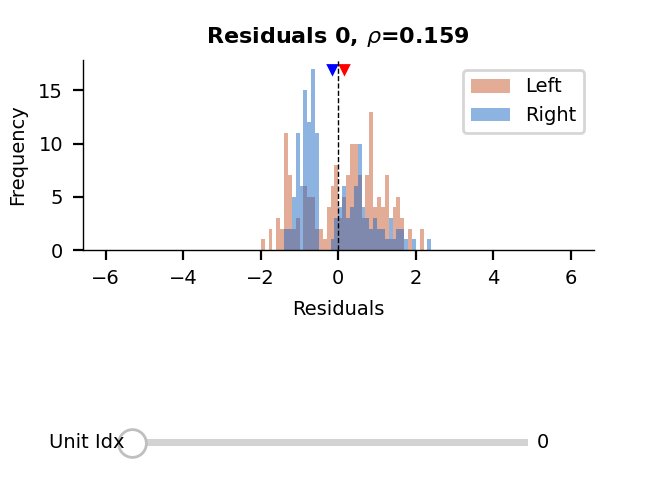

In [116]:
from matplotlib.widgets import Slider
# plot first trace
fig, ax = plt.subplots()
plt.subplots_adjust(bottom=0.5)

curr_idx = 0
counts_left, edges_left, bars_left  = ax.hist(res_left[:, curr_idx], color="#C65B31", alpha=0.5, bins=np.linspace(-6, 6, 121), label="Left")
counts_right, edges_right, bars_right = ax.hist(res_right[:,curr_idx], alpha=0.5, color="#1D68C4", bins=np.linspace(-6, 6, 121), label="Right")
mean_left,  =  ax.plot(torch.mean(res_left[:,curr_idx]), max(max(counts_left), max(counts_right)), 'v', color='red')
mean_right, = ax.plot(torch.mean(res_right[:,curr_idx]), max(max(counts_right), max(counts_right)), 'v', color='blue')

ax.axvline(0, linestyle='--', linewidth=0.5, color='k')
ax.legend()
        
ax.set_title(fr"Residuals {curr_idx}, $\rho$={res_block_corr[curr_idx]:.3f}")
ax.set_xlabel("Residuals")
ax.set_ylabel("Frequency")

# slider
ax_slider = plt.axes([0.2, 0.1, 0.6, 0.03])
slider = Slider(
    ax=ax_slider,
    label="Unit Idx",
    valmin=0,
    valmax=res_left.shape[1] - 1,
    valinit=0,
    valstep=1  # makes slider move in integers
)

# update
def update(val):
    update_idx = int(slider.val)
    counts_left, _  = np.histogram(res_left[:, update_idx], bins=edges_left)
    counts_right, _ = np.histogram(res_right[:, update_idx], bins=edges_right)

    # Update bar heights
    for bar, height in zip(bars_left, counts_left):
        bar.set_height(height)

    for bar, height in zip(bars_right, counts_right):
        bar.set_height(height)
        
    mean_left.set_data([torch.mean(res_left[:, update_idx])], [max(max(counts_left), max(counts_right))])
    mean_right.set_data([torch.mean(res_right[:, update_idx])], [max(max(counts_right), max(counts_left))])
    ax.relim()
    ax.autoscale_view()
    ax.set_title(fr"Unit {update_idx}, $\rho$={res_block_corr[update_idx]:.3f}")
    fig.canvas.draw_idle()

slider.on_changed(update)

def on_key(event):
    step = 1
    if event.key == 'right':
        slider.set_val(slider.val + step)
    elif event.key == 'left':
        slider.set_val(slider.val - step)

fig.canvas.mpl_connect('key_press_event', on_key)

plt.show()

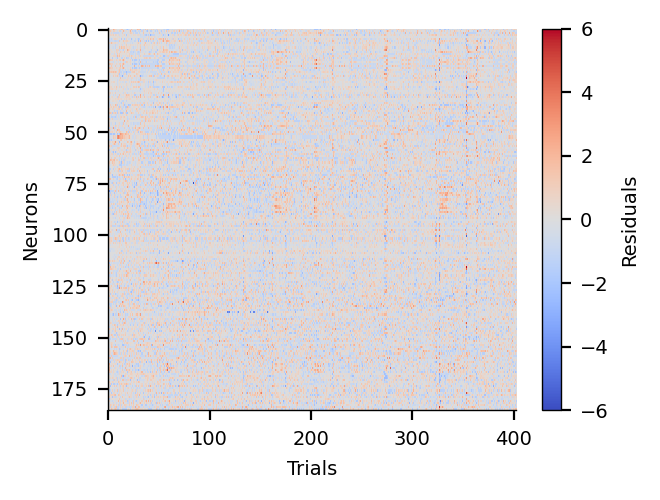

In [45]:
plt.figure()
plt.imshow(res.T, aspect='auto', interpolation='none', cmap='coolwarm', vmin=-6, vmax=6)
plt.colorbar(label="Residuals")
plt.xlabel("Trials"); plt.ylabel("Neurons")
plt.tight_layout(); plt.show()

In [ ]:
# try block and choice -> same thing
# sanity check colin

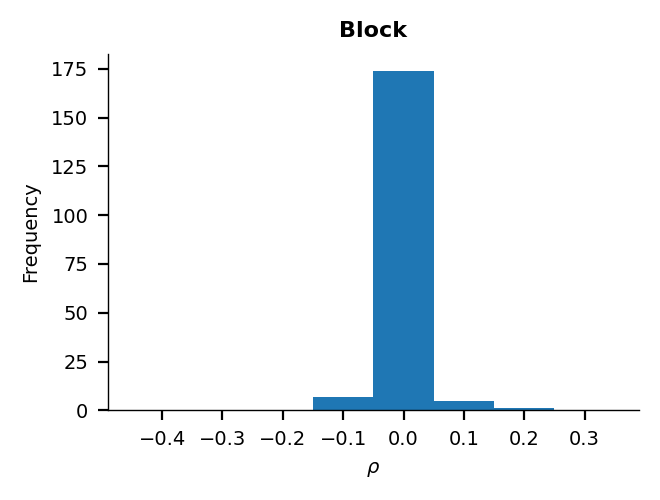

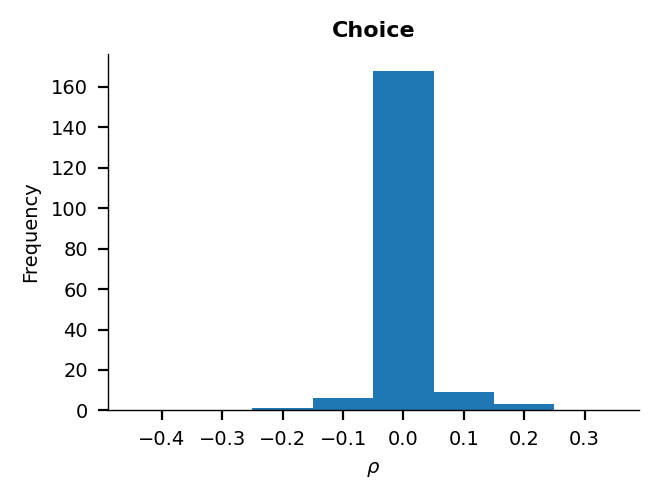

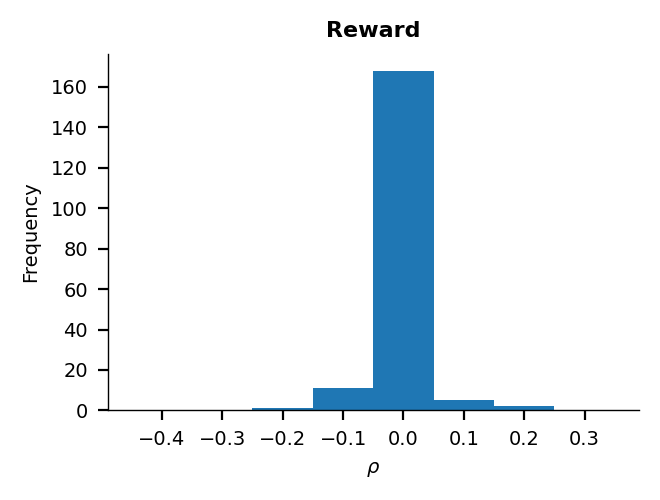

In [80]:
plt.figure() 
plt.hist(res_block_corr, bins=np.arange(-0.45, 0.45, 0.1))
plt.xlabel(r"$\rho$")
plt.ylabel("Frequency")
plt.title("Block")
plt.tight_layout(); plt.show()

plt.figure() 
plt.hist(res_choice_corr, bins=np.arange(-0.45, 0.45, 0.1))
plt.xlabel(r"$\rho$")
plt.ylabel("Frequency")
plt.title("Choice")
plt.tight_layout(); plt.show()

plt.figure() 
plt.hist(res_reward_corr, bins=np.arange(-0.45, 0.45, 0.1))
plt.xlabel(r"$\rho$")
plt.ylabel("Frequency")
plt.title("Reward")
plt.tight_layout(); plt.show()

### Are they actually collinear??????

In [ ]:
# can you write block_side as a linear combination of response and reward?
# no.. because xor is not linear

In [72]:
unique_c = trial_data.groupby(['block_side','rewarded'])['response'].nunique()
print(unique_c)

block_side  rewarded
-1          0           1
            1           1
 1          0           1
            1           1
Name: response, dtype: int64


In [58]:
np.nanmean((trial_data[left_block_mask_rc]['block_performance'] - trial_data[left_block_mask_b]['block_performance']).values)
np.nanmean((trial_data[right_block_mask_rc]['block_performance'] - trial_data[right_block_mask_b]['block_performance']).values)

np.float64(0.0)

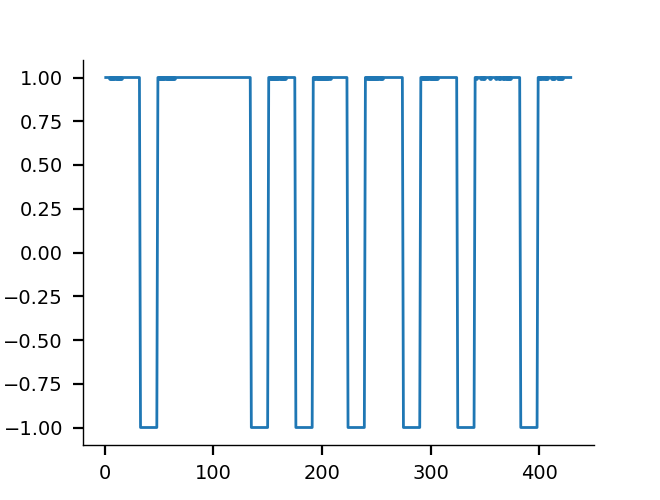

In [69]:
s = trial_data[left_block_mask_b]['block_performance']
idx = s[s.isna()].index
plt.figure()
plt.scatter(idx, np.tile(1, len(idx)), s=0.5)
plt.plot(trial_data['block_side'])
plt.show()

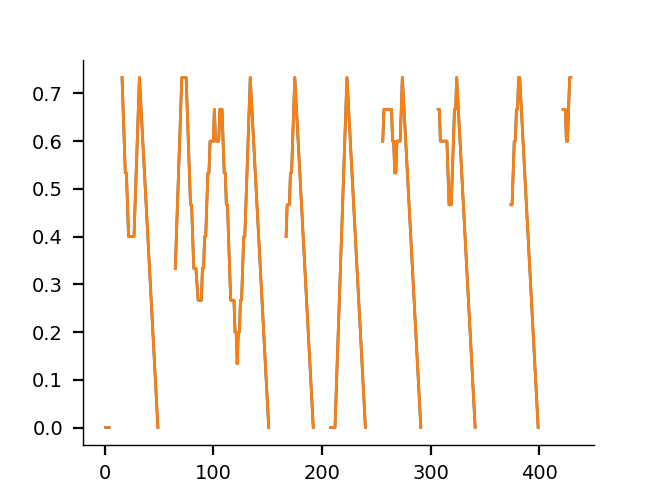

In [53]:
left_block_mask_rc  = ((trial_data['rewarded']==1) & (trial_data['response']==1)) | ((trial_data['rewarded']==0) & (trial_data['response']==-1))
right_block_mask_rc = ((trial_data['rewarded']==1) & (trial_data['response']==-1)) | ((trial_data['rewarded']==0) & (trial_data['response']==1))

left_block_mask_b  = (trial_data['block_side']==1)
right_block_mask_b = (trial_data['block_side']==-1)

# print((trial_data[left_block_mask_rc]  == trial_data[left_block_mask_b]).all())
# print((trial_data[right_block_mask_rc] == trial_data[right_block_mask_b]).all())

plt.figure()
plt.plot(trial_data[left_block_mask_rc]['block_performance'])
plt.plot(trial_data[left_block_mask_b]['block_performance'])
plt.show()

--------

In [ ]:
# look at where neurons with high coupling weight fall in the correlation histogram
# find residuals from task variable model after latent fit
# set max_iter to 1 st it does not refit the task variables

In [ ]:
res_block_corr[np.argmax(res_tv['r2test'])]

In [ ]:
plt.figure()
plt.plot(robs[:,np.argmax(res_tv['r2test'])], color="#666666", alpha=0.5, label="robs")
plt.plot(rhat[:,np.argmax(res_tv['r2test'])], color="#5C2392", alpha=0.5, label="rhat")
plt.plot(res[:,np.argmax(res_tv['r2test'])], color="#A11B1B", label="res")
plt.plot(block_side, color="#000000", label='block')
plt.xlabel("Trials")
plt.ylabel("Spike Counts")
plt.title(fr"Top $r^2$ Unit (idx={np.argmax(res_tv['r2test'])}), block $\rho$ = {res_block_corr[np.argmax(res_tv['r2test'])].round(3)}")
plt.legend()
plt.tight_layout(); plt.show()

In [ ]:
plt.figure()
plt.plot(robs[:,np.argmax(np.abs(res_block_corr))], color="#666666", alpha=0.5, label="robs")
plt.plot(rhat[:,np.argmax(np.abs(res_block_corr))], color="#5C2392", alpha=0.5, label="rhat")
plt.plot(res[:,np.argmax(np.abs(res_block_corr))], color="#A11B1B", label="res")
plt.plot(block_side, color="#000000", label='block')
plt.xlabel("Trials")
plt.ylabel("Spike Counts")
plt.title(fr"Top block $\rho$ Unit (idx={np.argmax(np.abs(res_block_corr))}), block $\rho$ = {res_block_corr[np.argmax(np.abs(res_block_corr))].round(3)}")
plt.legend()
plt.tight_layout(); plt.show()

In [ ]:
fitlvm_utils.plot_r2(res_baseline, label_a="Baseline", save=False)

In [ ]:
# Step 2a: Evaluate and plot comparison for baseline and task variable models
print("Step 2a: Eval")
res_baseline        = fitlvm_utils.eval_model(mod_baseline, data_gd, test_dl.dataset, do_plot=True, save=False)
res_tv              = fitlvm_utils.eval_model(mod_tv, data_gd, test_dl.dataset, do_plot=True, save=False)
fitlvm_utils.plot_r2_comp(res_baseline, res_tv, label_a="Baseline", label_b="Curr/Prev Ch./Rw.", save=False)

# Step 3a: Get units that had significant performance increase with a task variable model
print("Step3a: Inclusion Criteria")
cids = fitlvm_utils.get_cids(cids_pca, res_tv)

In [ ]:
# # Step 3b: Fit gain autoencoder
# # NOTE: fitting done by first fixing drift/tv, first pass fit latent weights; then refit drift/tv and latents independently
print("Step 3b: Gain AE")
mod_ae_gain = fitlvm_utils.fit_ae_gain(train_dl, val_dl, mod_tv, cids, num_tv, num_units, data_gd, num_latents=1) 

# Step 3c: Fit offset autoencoder
print("Step 3c: Offset AE")
mod_ae_offset = fitlvm_utils.fit_ae_offset(train_dl, val_dl, mod_tv, cids, num_tv, num_units, data_gd, num_latents=1)

# # Step 3d: Fit affine autoencoder
print("Step 3d: Affine AE")
mod_ae_affine, r2 = fitlvm_utils.fit_ae_affine(train_dl, val_dl, test_dl, mod_tv, mod_ae_gain, mod_ae_offset, cids, num_tv, num_units, data_gd, device, num_latents=1)


In [ ]:
print("Step 3e: Eval")
res_affineae        = fitlvm_utils.eval_model(mod_ae_affine, data_gd, test_dl.dataset, do_plot=True, save=False)
res_tv              = fitlvm_utils.eval_model(mod_tv, data_gd, test_dl.dataset, do_plot=True, save=False)
_ = fitlvm_utils.plot_r2_comp(res_tv, res_affineae, label_a="TV", label_b="Affine", save=False)

In [ ]:
# Step 4a: Convert ae to lvm
# NOTE: the difference between affine and affineae is that affineae (step 3) is fit with weights initialized by an autoencoder
print("Step 4a: AE to LVM")
mod_ae_offset_lvm, mod_ae_gain_lvm, mod_ae_affine_lvm = fitlvm_utils.ae2lvm(train_dl, val_dl, mod_ae_offset, mod_ae_gain, mod_ae_affine, cids, num_tv, num_units, data_gd, num_latents=1, max_iters=10)


In [ ]:
print("Step 4b: Eval")
res_affineae        = fitlvm_utils.eval_model(mod_ae_affine, data_gd, test_dl.dataset, model="Autoencoder Affine", do_plot=True, save=False)
res_affineaelvm     = fitlvm_utils.eval_model(mod_ae_affine_lvm, data_gd, test_dl.dataset, model="Affine to Latent Variable Model, 10 Iters", do_plot=True, save=False)
fitlvm_utils.plot_r2_comp(res_affineae, res_affineaelvm, label_a="Affine", label_b="Affine (AE to LVM)", title="10 training iters after conversion", save=False)

In [ ]:
print("Step 4c: Eval")
res_offsetaelvm     = fitlvm_utils.eval_model(mod_ae_offset_lvm, data_gd, test_dl.dataset, model="Offset LVM, 10 Iters", do_plot=True, save=False)
fitlvm_utils.plot_r2_comp(res_tv, res_offsetaelvm, label_a="TV", label_b="Offset (AE to LVM)", title="10 training iters after conversion", save=False)

## Residuals

In [ ]:
from copy import deepcopy
mod_offset_nolatent = deepcopy(mod_ae_offset_lvm)
mod_offset_nolatent.readout_offset.weight.data[:] = 0
res_offset_nolatent = fitlvm_utils.eval_model(mod_offset_nolatent, data_gd, test_dl.dataset)

robs = val_dl.dataset[:]['robs']
rhat = res_offset_nolatent['rhat']
res = robs - rhat

block_side = np.where(trial_data['block_side']=='left', 1, -1)
choice = trial_data['response']
reward = trial_data['rewarded']

rob_block_corr = utils.spearmanr_vec(block_side, robs)
rob_choice_corr = utils.spearmanr_vec(choice, robs)
rob_reward_corr = utils.spearmanr_vec(reward, robs)
res_block_corr = utils.spearmanr_vec(block_side, res)
res_choice_corr = utils.spearmanr_vec(choice, res)
res_reward_corr = utils.spearmanr_vec(reward, res)

In [ ]:
plt.figure()
plt.imshow(res.T, aspect='auto', interpolation='none', cmap='coolwarm', vmin=-0.25, vmax=0.25)
plt.colorbar(label="Residuals")
plt.xlabel("Trials"); plt.ylabel("Neurons")
plt.tight_layout(); plt.show()

In [ ]:
plt.figure() 
plt.hist(res_reward_corr)
plt.xlabel(r"$\rho$")
plt.ylabel("Frequency")
plt.title("Reward")
plt.tight_layout(); plt.show()

In [ ]:
plt.figure()
plt.plot(robs[:,np.argmax(res_offset_nolatent['r2test'])], color="#666666", alpha=0.5, label="robs")
plt.plot(rhat[:,np.argmax(res_offset_nolatent['r2test'])], color="#5C2392", alpha=0.5, label="rhat")
plt.plot(res[:,np.argmax(res_offset_nolatent['r2test'])], color="#A11B1B", label="res")
plt.plot(block_side, color="#000000", label='block')
plt.xlabel("Trials")
plt.ylabel("Spike Counts")
plt.title(fr"Top $r^2$ Unit (idx={np.argmax(res_offset_nolatent['r2test'])}), block $\rho$ = {res_block_corr[np.argmax(res_offset_nolatent['r2test'])].round(3)}")
plt.legend()
plt.tight_layout(); plt.show()

In [ ]:
plt.figure()
plt.plot(robs[:,np.argmax(np.abs(res_block_corr))], color="#666666", alpha=0.5, label="robs")
plt.plot(rhat[:,np.argmax(np.abs(res_block_corr))], color="#5C2392", alpha=0.5, label="rhat")
plt.plot(res[:,np.argmax(np.abs(res_block_corr))], color="#A11B1B", label="res")
plt.plot(block_side, color="#000000", label='block')
plt.xlabel("Trials")
plt.ylabel("Spike Counts")
plt.title(fr"Top block $\rho$ Unit (idx={np.argmax(np.abs(res_block_corr))}), block $\rho$ = {res_block_corr[np.argmax(np.abs(res_block_corr))].round(3)}")
plt.legend()
plt.tight_layout(); plt.show()

In [ ]:
# try to freeze tv when training affine

In [ ]:
plt.figure(); plt.imshow(res.T, aspect='auto', interpolation='none', cmap='coolwarm', vmin=-1, vmax=1); plt.colorbar(); plt.show()

In [ ]:
plt.figure(); plt.hist(res_block_corr); plt.show()
plt.figure(); plt.hist(res_choice_corr); plt.show()
plt.figure(); plt.hist(res_reward_corr); plt.show()

## Evaluation

In [ ]:
# EVALUATION
print("Evaluating...")
das_sess = fitlvm_utils.get_das(trial_data, regions, sample, train_inds, val_inds, test_inds, train_dl, test_dl, mod_baseline, mod_tv, mod_ae_offset, mod_ae_gain, mod_ae_affine, mod_ae_offset_lvm, mod_ae_gain_lvm, mod_ae_affine_lvm, cids, data_gd, do_save=False, do_plot=True)

In [ ]:
# offset
fitlvm_utils.plot_summary(das_sess, subj_idx=subj_idx, sess_idx=sess_idx, sort_by="offset", model_name="offsetae_lvm")

In [ ]:
# affine
fitlvm_utils.plot_summary(das_sess, subj_idx=subj_idx, sess_idx=sess_idx)

## Grid Search

In [ ]:
# SERIAL
out = [fit_models.fit_sess(unit_spike_times_all[subj_idx][sess_idx], trial_data_all[subj_idx][sess_idx], session_data_all[subj_idx][sess_idx], regions_all[subj_idx][sess_idx], subj_idx, sess_idx, num_latents=latent_idx) for latent_idx in range(1,8+1)]
das = [out[latent_idx][0] for latent_idx in range(8)]

In [ ]:
# PARALLEL
def fit_sess_latents_gs(subj_idx, sess_idx):
    return Parallel(n_jobs=-1, backend='loky')(delayed(fit_models.fit_sess)(unit_spike_times_all[subj_idx][sess_idx], trial_data_all[subj_idx][sess_idx], session_data_all[subj_idx][sess_idx], regions_all[subj_idx][sess_idx], subj_idx, sess_idx, num_latents=num_latents) for num_latents in range(1,8+1))
out = fit_sess_latents_gs(subj_idx=subj_idx, sess_idx=sess_idx) 
das = [out[latent_idx][0] for latent_idx in range(8)]
np.save('vars/das_03_latents.npy', das)

In [ ]:
# PARALLEL
out = fit_sess_latents_gs(subj_idx=0, sess_idx=2) 
das = [out[latent_idx][0] for latent_idx in range(8)]
np.save('vars/das_02_latents.npy', das)

In [ ]:
# PARALLEL
out = fit_sess_latents_gs(subj_idx=0, sess_idx=1) 
das = [out[latent_idx][0] for latent_idx in range(8)]
np.save('vars/das_01_latents.npy', das)

In [ ]:
# PARALLEL
out = fit_sess_latents_gs(subj_idx=0, sess_idx=0) 
das = [out[latent_idx][0] for latent_idx in range(8)]
np.save('vars/das_00_latents.npy', das)

In [ ]:
# PARALLEL
out = fit_sess_latents_gs(subj_idx=0, sess_idx=4) 
das = [out[latent_idx][0] for latent_idx in range(8)]
np.save('vars/das_04_latents.npy', das)

In [ ]:
from lib import eval_models

In [ ]:
eval_models.plot_r2_laatents(das, subj_idx=0, sess_idx=3, is_msess=False)

In [ ]:
eval_models.plot_r2_latents(das, subj_idx=0, sess_idx=3, is_msess=False, ae=False)

In [ ]:
def bah(das, num_latents, ae=True, mult=True):
    plt.figure()
    model = das['affineae'] if ae else das['affine']
    weights = model['model'].gain_mu.get_weights() if mult else model['model'].offset_mu.get_weights() 
    for ax in range(num_latents):
        plt.plot(weights[:,ax], alpha=0.5, label=f"Latent {ax+1}")
    plt.title(f"Total # Latents: {num_latents}")
    plt.legend()

In [ ]:
for num_latents in range(1, 8+1): 
    bah(das[num_latents-1], num_latents=num_latents, ae=False)
     